In [230]:
import os
import pyspark
# from pyspark.storagelevel import StorageLevel
import re
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import datetime

In [181]:
# jar_path = "./gcs-connector-hadoop2-latest.jar"

In [182]:
# conf = pyspark.SparkConf().set("spark.jars", jar_path)

In [183]:
sc = pyspark.SparkContext(appName='p')

In [184]:
sc

<SparkContext master=local[*] appName=p>

In [185]:
# conf = sc._jsc.hadoopConfiguration()

In [186]:
# conf.set(
#     "fs.gs.impl", 
#     "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem")

In [187]:
# conf.set(
#     "google.cloud.auth.service.account.json.keyfile",
#     "../../../FireDepartment/distributedcomputing-369720-f5b1271acef3.json",
# )

In [188]:
# file = sc.textFile(
#     "gs://dc-msds694/*"
# )

In [189]:
# file.count()

In [190]:
rdd=sc.textFile('Fire_Department_Calls_for_Service.csv')

In [191]:
# rdd.take(50000)

In [192]:
rdd.take(1)

['Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,RowID,case_location,Analysis Neighborhoods']

In [193]:
rdd=rdd.map(lambda x: x.split(','))

In [194]:
header=rdd.take(1)
header

[['Call Number',
  'Unit ID',
  'Incident Number',
  'Call Type',
  'Call Date',
  'Watch Date',
  'Received DtTm',
  'Entry DtTm',
  'Dispatch DtTm',
  'Response DtTm',
  'On Scene DtTm',
  'Transport DtTm',
  'Hospital DtTm',
  'Call Final Disposition',
  'Available DtTm',
  'Address',
  'City',
  'Zipcode of Incident',
  'Battalion',
  'Station Area',
  'Box',
  'Original Priority',
  'Priority',
  'Final Priority',
  'ALS Unit',
  'Call Type Group',
  'Number of Alarms',
  'Unit Type',
  'Unit sequence in call dispatch',
  'Fire Prevention District',
  'Supervisor District',
  'Neighborhooods - Analysis Boundaries',
  'RowID',
  'case_location',
  'Analysis Neighborhoods']]

In [195]:
body = rdd.filter(lambda x: x not in header)
body.take(1)

[['221210313',
  'E36',
  '22054955',
  'Outside Fire',
  '05/01/2022',
  '04/30/2022',
  '05/01/2022 02:58:25 AM',
  '05/01/2022 02:59:15 AM',
  '05/01/2022 02:59:25 AM',
  '05/01/2022 03:01:06 AM',
  '05/01/2022 03:02:27 AM',
  '',
  '',
  'Fire',
  '05/01/2022 03:05:00 AM',
  'GOUGH ST/GROVE ST',
  'San Francisco',
  '94102',
  'B02',
  '36',
  '3265',
  '3',
  '3',
  '3',
  'true',
  'Fire',
  '1',
  'ENGINE',
  '1',
  '2',
  '5',
  'Hayes Valley',
  '221210313-E36',
  'POINT (-122.42316555403964 37.77781524520032)',
  '9']]

## Ity:

#### Analytical Goal: Check which call type group has most number alarms (distribution of alarms per call type group)

##### Get Call type, call type group, latitude, longitude and number of alarms from the data

In [196]:
def get_long_lat(x):
    a=re.findall(r'POINT \((.*) (.*)\)',x)
    return float(a[0][0]),float(a[0][1])
    
req_rdd1=body.filter(lambda x: x[26] not in ['','Potentially Life-Threatening', \
                                             'Non Life-threatening', 'Fire', 'Alarm', \
                                             'true', 'false'] and \
                    x[25] != '')\
                    .map(lambda x: (x[3], x[25], int(x[26]), get_long_lat(x[33])[0], get_long_lat(x[33])[1]))
                    
req_rdd1.take(3)

[('Outside Fire', 'Fire', 1, -122.42316555403964, 37.77781524520032),
 ('Alarms', 'Alarm', 1, -122.39469970274361, 37.76460987856451),
 ('Alarms', 'Alarm', 1, -122.42057572093252, 37.76418194637148)]

In [197]:
## Get number of alarms for each group type
alarms_per_call_typ_grp = req_rdd1.map(lambda x: (x[1],x[2])).reduceByKey(lambda x,y: x+y)

In [198]:
alarms_per_call_typ_grp.take(6)

[('Potentially Life-Threatening', 1536824),
 ('Fire', 142999),
 ('Alarm', 752070),
 ('Non Life-threatening', 774563)]

In [199]:
## Convert rdd to dataframe
df_ctg_alarms=pd.DataFrame(alarms_per_call_typ_grp.sortBy(lambda x: x[1]).take(5), columns=['call type group', 'number of alarms'])

#### Display bar chart for number of alarms per call type group

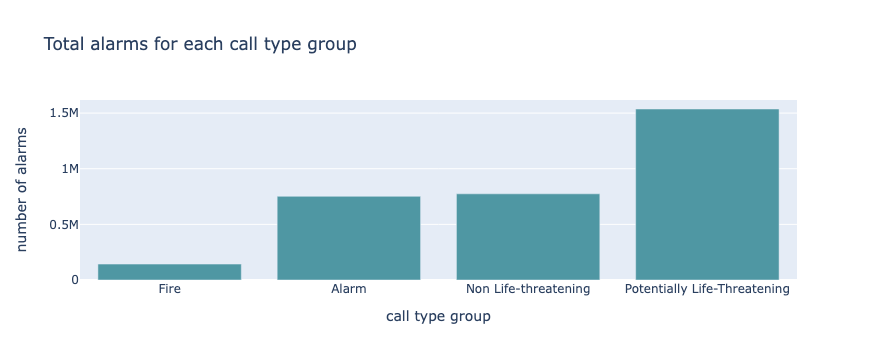

In [200]:
fig=px.bar(df_ctg_alarms, x='call type group', y='number of alarms', title='Total alarms for each call type group')
fig.update_traces(marker_color='#4F97A3')
fig.show()

##### Observation: The most number of alarms are 'Potentially Life-Threatening' (~1.5M)

#### Analytical Goal: Check the call type groups and the number of alarms for each location

In [201]:
## Convert geo data to dataframe
geo_df = pd.DataFrame(req_rdd1.take(10000), columns=['callType', 'Call Type Group', 'alarms', 'lon', 'lat'])

/var/folders/3d/zfjrgdt504sdl7lwj8pz9lgc0000gn/T/ipykernel_24277/1021065833.py:12: UserWarning:

The palette list has more values (5) than needed (4), which may not be intended.



Text(0.5, 1.0, 'Number of alarms by call type group in SF (on sampled data)')

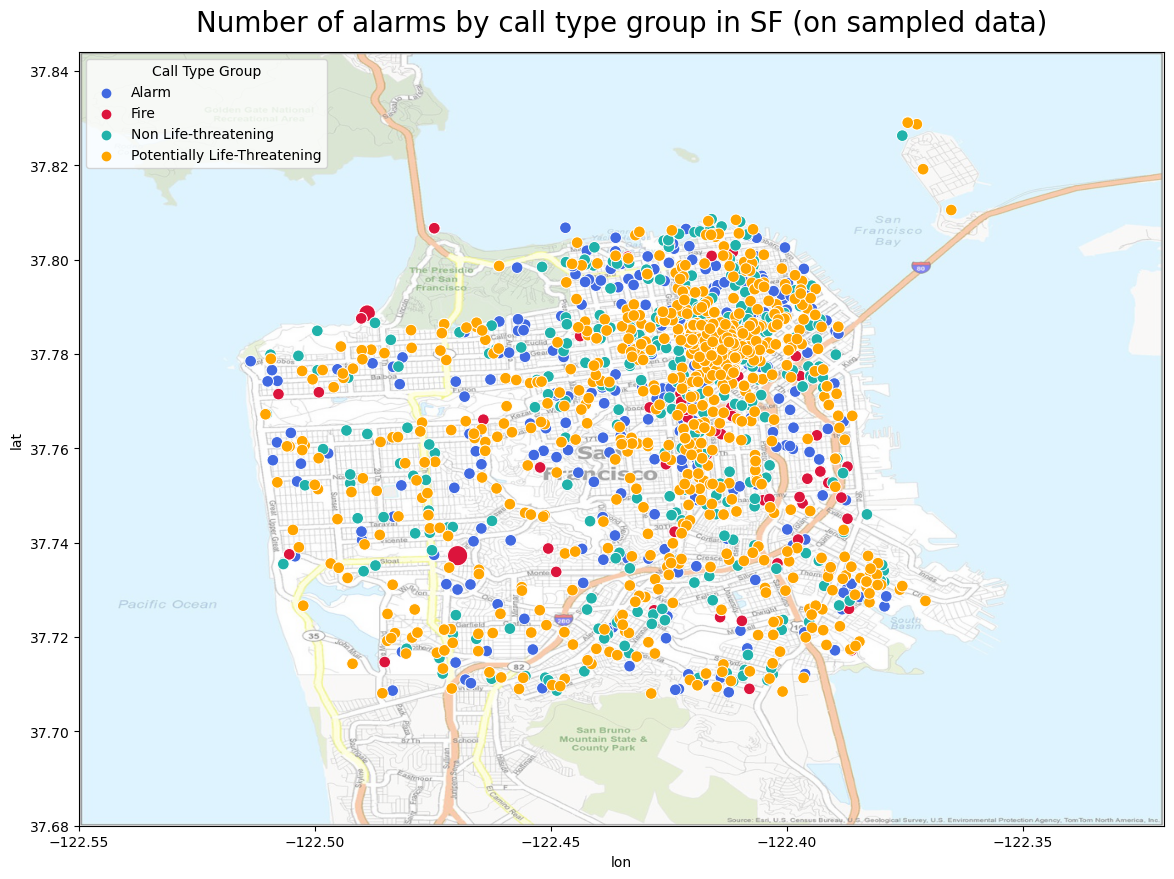

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize = (14, 15))
img = plt.imread("sf_map.jpeg")
ax.imshow(img, extent=[-122.55, -122.32, 37.68, 37.844], alpha = 0.5)
colors = ["royalblue","crimson","lightseagreen","orange","lightgrey"]
# colors = ["crimson","lightseagreen","orange","lightgrey"]

df_scatter = geo_df.groupby('Call Type Group', group_keys=False).apply(lambda x: x.sample(frac=0.2))

ax = sns.scatterplot(data=df_scatter, x="lon", y="lat", hue="Call Type Group",\
                     s = df_scatter['alarms']*70, palette=colors)
ax.set_title('Number of alarms by call type group in SF (on sampled data)', fontsize=20, pad=15)


##### Observation: Most of the fire incidents have taken place close to Union Square and Tenderloin

## Tejashree:

### Analytical Goal: Call Final Disposition per zip code of incident

In [203]:
def retrieve_column(array, col):
    try:
        return array[col]
    except:
        pass

def convert_string_to_timestamp(string):
    try:
        return datetime.strptime(string, '%Y-%M-%d').date()
    except:
        pass
 
 
def string_to_int(x):
    try:
        return int(x)
    except:
        return 0

def convert_none(x):
    if x=="":
        return None
    else:
        return x

In [204]:
body.take(1)[0][17]

'94102'

In [205]:
## Get the call type and zipcode
parsed_input = body.map(lambda x : (convert_none(retrieve_column(x,13)), 
                                     convert_none(retrieve_column(x,17))))\
                    .cache()

In [206]:
parsed_input.take(2)

[('Fire', '94102'), ('Fire', '94107')]

In [208]:
## Convert rdd to dataframe
disposition_zip_df = pd.DataFrame(data = parsed_input.collect(), columns=['Call Final Disposition', 'Zipcode of Incident'])
disposition_zip_df.head()

,Call Final Disposition,Zipcode of Incident
0,Fire,94102
1,Fire,94107
2,Fire,94110
3,Fire,94102
4,Fire,94109


In [209]:
## Get count per group
incident_count = disposition_zip_df.groupby(['Call Final Disposition']).count()[67:]
incident_count.rename({'Zipcode of Incident':'Zipcode Count'}, inplace=True, axis=1)

In [210]:
incident_count

,Zipcode Count
Call Final Disposition,
Against Medical Advice,67910
CHP,973
Cancelled,68569
Code 2 Transport,1774428
Code 3 Transport,155187
Duplicate,1423
Fire,811645
Gone on Arrival,18516
Medical Examiner,46511


#### Display bar char representing the number of zipcodes per final call disposition

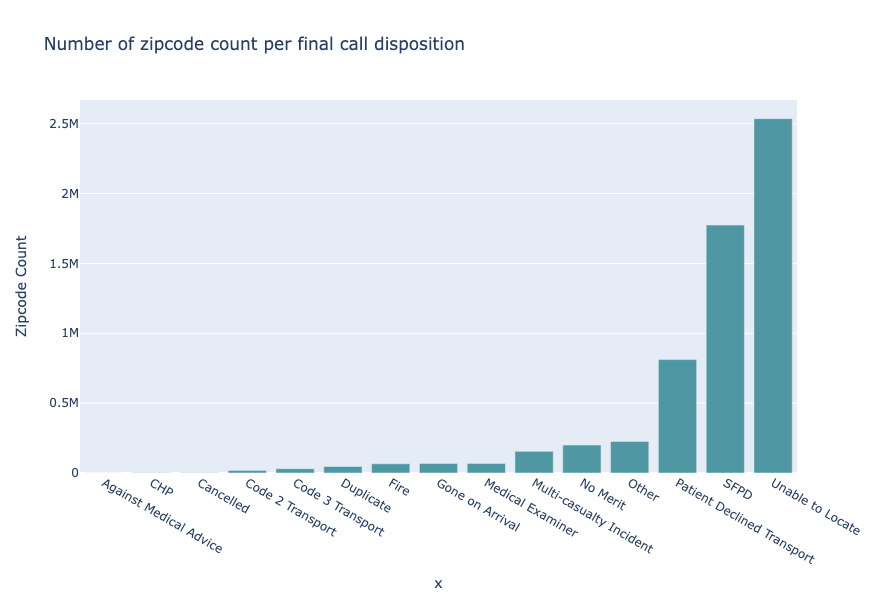

In [211]:
fig=px.bar(incident_count.sort_values('Zipcode Count'), y='Zipcode Count', x=incident_count.index, height=600, title='Number of zipcode count per final call disposition')
fig.update_traces(marker_color='#4F97A3')
fig.show()

##### Observation: Unable to locate zipcodes has the major proportion of zipcode count.

## Tim:

### Analytical Goal: Check for fire incidents on seasonal basis (if there is any season when there are more calls)

In [217]:
fire_call_date = body.map(lambda x: x[4])

In [218]:
def to_season(month):
    """
    0: Spring
    1: Summer
    2: Fall
    3: Winter
    """
    if month <= 3:
        return 0
    elif month <= 6:
        return 1
    elif month <= 9:
        return 2
    else:
        return 3

In [219]:
## Get date and convert to season
season_encode = fire_call_date.map(lambda x: x.split("/")[0]).map(lambda x: int(x)).map(lambda x: to_season(x))
season_encode.take(10)

[1, 0, 1, 3, 1, 1, 2, 3, 1, 2]

In [220]:
## Convert rdd to dataframe
s_df = pd.DataFrame(season_encode.take(10000), columns=["season"])
season_count = s_df.value_counts().sort_index(ascending=True)

In [221]:
## Get count per season
season_count.index = ["Spring", "Summer", "Fall", "Winter"]
df = pd.DataFrame({'Season':season_count.index, 'count':season_count.values})
df["count"].values

array([1998, 4466, 1880, 1656])

#### Display pie chart representing the calls per season

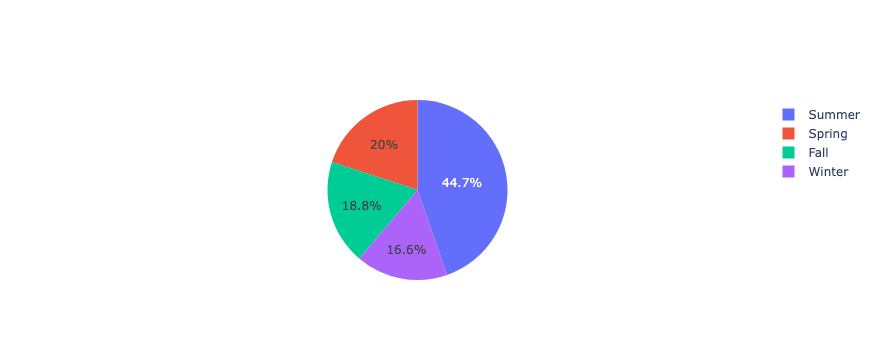

In [224]:
# plotly.offline.init_notebook_mode(connected = True)
fig = go.Figure(data=[go.Pie(labels=df.Season.values, values=df["count"].values)])
fig.show()

##### Observation: Summer has the most fire disasters.

## Mohana:

### Analytical goal: Checking for fire incidents happenings based on the counts of calls

In [225]:
recs = body.filter(lambda x: x[13] != 'Duplicate')

In [228]:
## Get the dates form the data
date_recs = recs.map(lambda x: x[0:4] + [x[4].strip()[:10]] + x[5:]
                     ).filter(lambda x: bool(re.match('\d{2}/\d{2}/\d{4}', x[4])))
#date_recs = date_recs.sortBy(lambda x: x[4])
date_recs.take(2)

[['221210313',
  'E36',
  '22054955',
  'Outside Fire',
  '05/01/2022',
  '04/30/2022',
  '05/01/2022 02:58:25 AM',
  '05/01/2022 02:59:15 AM',
  '05/01/2022 02:59:25 AM',
  '05/01/2022 03:01:06 AM',
  '05/01/2022 03:02:27 AM',
  '',
  '',
  'Fire',
  '05/01/2022 03:05:00 AM',
  'GOUGH ST/GROVE ST',
  'San Francisco',
  '94102',
  'B02',
  '36',
  '3265',
  '3',
  '3',
  '3',
  'true',
  'Fire',
  '1',
  'ENGINE',
  '1',
  '2',
  '5',
  'Hayes Valley',
  '221210313-E36',
  'POINT (-122.42316555403964 37.77781524520032)',
  '9'],
 ['220190150',
  'E29',
  '22008871',
  'Alarms',
  '01/19/2022',
  '01/18/2022',
  '01/19/2022 01:42:12 AM',
  '01/19/2022 01:44:13 AM',
  '01/19/2022 01:44:28 AM',
  '01/19/2022 01:46:47 AM',
  '01/19/2022 01:49:32 AM',
  '',
  '',
  'Fire',
  '01/19/2022 02:35:26 AM',
  '100 Block of MISSISSIPPI ST',
  'San Francisco',
  '94107',
  'B03',
  '29',
  '2431',
  '3',
  '3',
  '3',
  'true',
  'Alarm',
  '1',
  'ENGINE',
  '1',
  '3',
  '10',
  'Potrero Hill',
  

In [231]:
## Clean and format the dates
date_recs = date_recs.map(lambda x: x[0:4]+[datetime.datetime.strptime(x[4], '%m/%d/%Y').date()] + x[5:]).sortBy(
    lambda x: x, ascending=True)

#### Number of calls per day

In [233]:
dict_calls = date_recs.map(lambda x: x[4]).countByValue()

In [ ]:
## Converting rdd to dataframe
df = pd.DataFrame({'date' : dict_calls.keys(), 'count': dict_calls.values()})

#### Display box plot showing distribution of daily counts

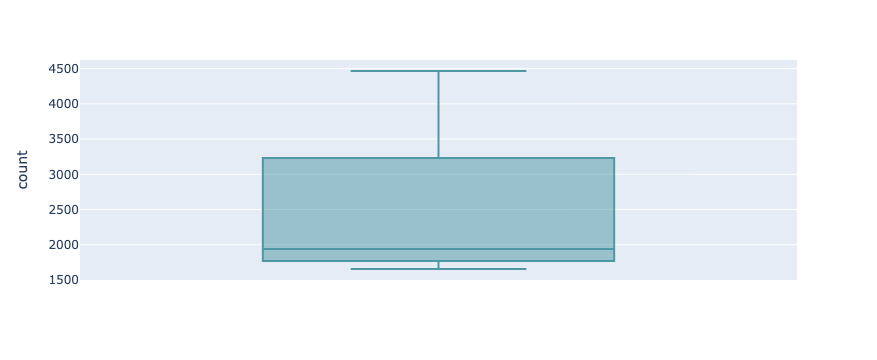

In [234]:
fig = px.box(df, y="count")
fig.update_traces(marker_color='#4F97A3')
fig.show()

In [235]:
def year_days(x):
    if (int(x) % 4 == 0):
        return 366
    return 365

In [237]:
## Get counts per year
year_rdd = date_recs.map(lambda x: (str(x[4].year), 1)).reduceByKey(
    lambda x, y: x + y).map(lambda x: (x[0], x[1]//year_days(x[0]))).sortBy(lambda x: x[0], ascending=True)

#### Display bar chart with trend line showing the counts of calls per year as well as the trend

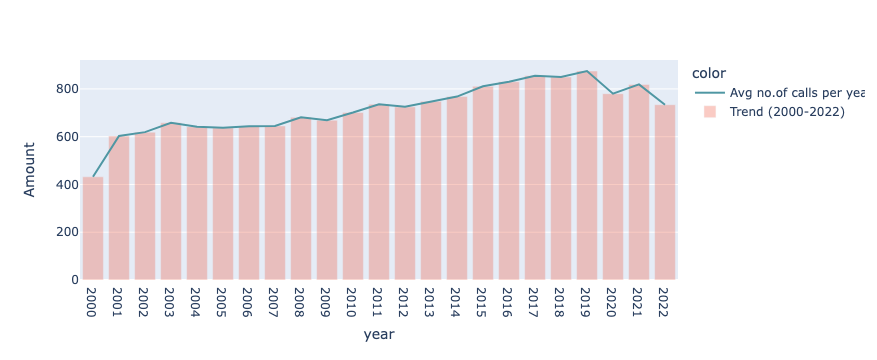

In [238]:
fig = px.line(x=year_rdd.keys().collect(), y=year_rdd.values().collect(), color=px.Constant("Avg no.of calls per year"),
             labels=dict(x="year", y="Amount"), color_discrete_sequence=["#4F97A3"])
fig.add_bar(x=year_rdd.keys().collect(), y=year_rdd.values().collect(), name="Trend (2000-2022)", opacity=0.3)
fig.show()

##### Observation: There is an increasing trend over the years (almost doubled). We received the highest average number of calls during the years 2017-2019 and thereafter, the daily average slightly dropped. Typically, 641-812 fire incident calls are happening every day.

In [239]:
sc.stop()